In [1]:
import os.path as osp
from utils import *
import mmcv
import torch
import wandb
from mmcv import Config
from mmcv.parallel import MMDistributedDataParallel
from mmdet.apis import set_random_seed, train_detector
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from algo2_result_to_aligned_result import algo2_result_to_aligned_result
# Let's take a look at the dataset image
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from xml_to_np import xml_to_np
from AP import calc_iou_individual, get_single_image_results
from soft_nms import py_cpu_softnms
from dbscan_result_to_aligned_result import dbscan_result_to_aligned_result
from AP import calc_iou_individual
import xml.etree.ElementTree as ET
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from utils import print_LC

In [2]:
checkpoint_file = '/home/aiarhipov/centernet/exps/20_cycle_middle_pairing_loss_speedup/epoch_15.pth'

config_file = "/home/aiarhipov/centernet/exps/20_cycle_l1/config.py"
cfg = Config.fromfile(config_file)

set_random_seed(0, deterministic=False)

dataset = build_dataset(cfg.data.test)

model = build_detector(cfg.model)
model.CLASSES = dataset.CLASSES

model = init_detector(config_file, checkpoint_file, device='cuda:3')

loading annotations into memory...
Done (t=5.59s)
creating index...
index created!
load checkpoint from local path: /home/aiarhipov/centernet/exps/20_cycle_middle_pairing_loss_speedup/epoch_15.pth


2023-05-11 20:03:01,315 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2023-05-11 20:03:01,325 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2023-05-11 20:03:01,327 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


In [ ]:
conf_threshold = 0.5
iou_threshold = 0.9
res = []
# for idx in tqdm(range(int(len(dataset)))):
idx = 7
anno = dataset.get_ann_info(idx=idx)
boxes = anno["bboxes"]
segm_path = anno["seg_map"]
xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"
print(img_path)
gt_boxes = xml_to_np(xml_path)
# print(f"gt_boxes[0] = {gt_boxes[:5]}")
pred = inference_detector(model, img_path)[0]
# print(f"pred[0] = {pred[:5]}")
conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
# print(f"conf_indexes = {conf_indexes}")
conf_pred = pred[conf_indexes]
# print(f"conf_pred[0] = {conf_pred[:5]}")
# if conf_pred.shape[0] > 1:
#     conf_pred = dbscan_result_to_aligned_result([conf_pred])
#     if conf_pred:
#         conf_pred = conf_pred[0]
#         print(gt_boxes[:, :4].shape)
#         print(conf_pred[:, :4].shape)

/home/aiarhipov/datasets/WTW-dataset/test/images/c6241cb65d32cb0e0838312ca386c7adc8c0b3a6.jpg


In [ ]:
import warnings
from pathlib import Path

import mmcv
import numpy as np
import torch
from mmcv.ops import RoIPool
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.models import build_detector
imgs = img_path
if isinstance(imgs, (list, tuple)):
    is_batch = True
else:
    imgs = [imgs]
    is_batch = False

cfg = model.cfg
device = next(model.parameters()).device  # model device

if isinstance(imgs[0], np.ndarray):
    cfg = cfg.copy()
    # set loading pipeline type
    cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)

datas = []
for img in imgs:
    # prepare data
    if isinstance(img, np.ndarray):
        # directly add img
        data = dict(img=img)
    else:
        # add information into dict
        data = dict(img_info=dict(filename=img), img_prefix=None)
    # build the data pipeline
    data = test_pipeline(data)
    datas.append(data)

data = collate(datas, samples_per_gpu=len(imgs))
# just get the actual data from DataContainer
data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]
if next(model.parameters()).is_cuda:
    # scatter to specified GPU
    data = scatter(data, [device])[0]
else:
    for m in model.modules():
        assert not isinstance(
            m, RoIPool
        ), 'CPU inference with RoIPool is not supported currently.'

# forward the model
with torch.no_grad():
    results = model(return_loss=False, rescale=True, **data)

print(1)
model.forward(data['img'], data['img_metas'], return_loss=False)

1


[[array([[301.24, 388.58, 301.24, 388.58,   0.86],
         [301.12, 676.64, 301.12, 676.64,   0.86],
         [121.63, 316.66, 121.63, 316.66,   0.86],
         ...,
         [ 17.59, 743.75,  58.65, 778.3 ,   0.07],
         [309.68, 783.68, 309.68, 783.68,   0.07],
         [660.67, 491.9 , 660.72, 491.82,   0.07]], dtype=float32)]]

In [19]:
inference_detector(model, img_path)

[array([[301.24, 388.58, 301.24, 388.58,   0.86],
        [301.12, 676.64, 301.12, 676.64,   0.86],
        [121.63, 316.66, 121.63, 316.66,   0.86],
        ...,
        [ 17.59, 743.75,  58.65, 778.3 ,   0.07],
        [309.68, 783.68, 309.68, 783.68,   0.07],
        [660.67, 491.9 , 660.72, 491.82,   0.07]], dtype=float32)]

In [11]:
# conf_pred = conf_pred.astype(int)
# conf_pred[0, 0], conf_pred[0, 2]
# conf_pred = conf_pred[(conf_pred[:, 0] != conf_pred[:, 2]) & (conf_pred[:, 1] != conf_pred[:, 3])]

In [12]:
print(conf_pred)

[[301.24 388.58 301.24 388.58   0.86]
 [301.12 676.64 301.12 676.64   0.86]
 [121.63 316.66 121.63 316.66   0.86]
 ...
 [300.26 460.63 300.26 460.63   0.43]
 [ 12.78 495.51  12.78 495.51   0.43]
 [ 12.87 387.92  12.87 387.92   0.43]]


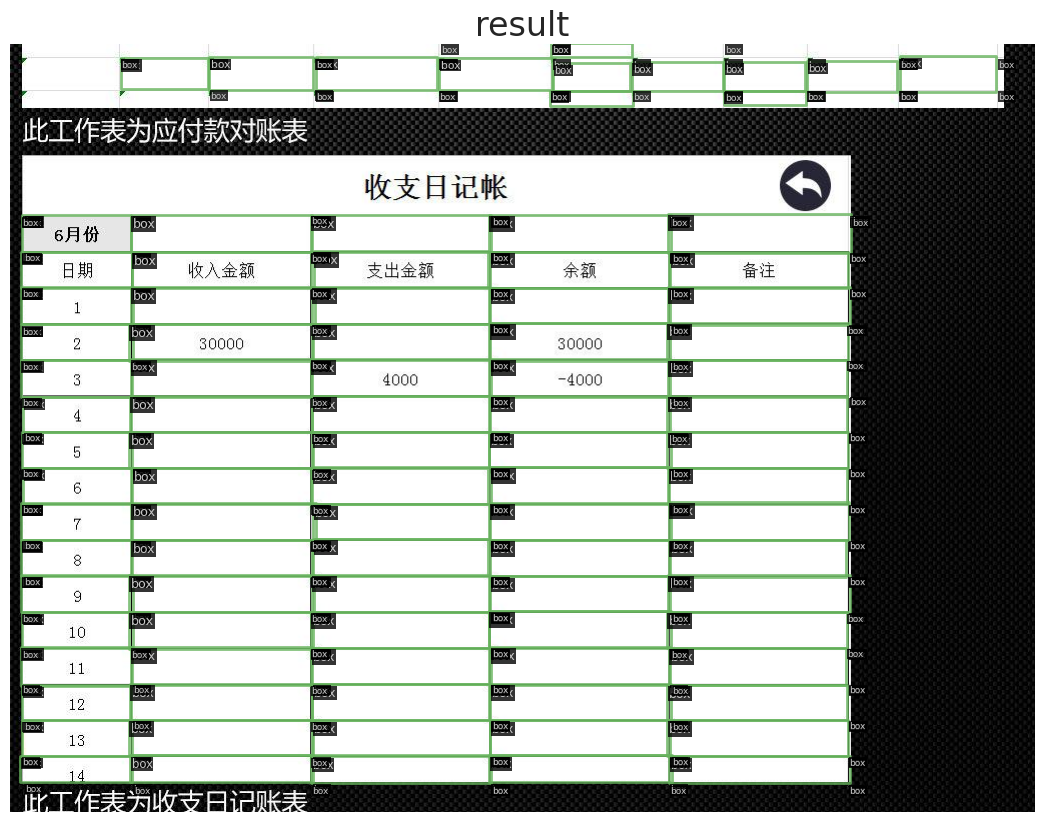

In [13]:
show_result_pyplot(model, img_path, [conf_pred[:, :4]], score_thr = 0)

In [7]:
def LC_for_dbscan_algo(pred):
    res = np.pad(pred, ((0,0),(0,4)), mode="constant", constant_values=np.nan)
    # left_edge.append(((box[0], box[1]), (box[0], box[3])))
    # right_edge.append(((box[2], box[1]), (box[2], box[3])))
    # up_edge.append(((box[0], box[1]), (box[2], box[1])))
    # down_edge.append(((box[0], box[3]), (box[2], box[3])))
    x = np.unique(np.hstack((pred[:, 0], pred[:, 2])))
    y = np.unique(np.hstack((pred[:, 1], pred[:, 3])))
    for idx, box in enumerate(pred):
        startrow = np.where(np.isclose(y, box[1]))[0][0]
        endrow = np.where(np.isclose(y, box[3]))[0][0] - 1
        startcolumn = np.where(np.isclose(x, box[0]))[0][0]
        endcolumn = np.where(np.isclose(x, box[2]))[0][0] - 1
        res[idx, -1] = endcolumn
        res[idx, -2] = startcolumn
        res[idx, -3] = endrow
        res[idx, -4] = startrow
    return res
    
# print_LC(img_path, LC_for_dbscan_algo(conf_pred))

In [8]:
conf_pred = LC_for_dbscan_algo(conf_pred)
matched_gt = np.insert(gt_boxes, 4, np.nan, axis=1)
for idx, g in enumerate(gt_boxes):
    
    iou = pd.Series([calc_iou_individual(p[:4], g[:4]) for p in conf_pred])
    max_idx = iou.argmax()
    max_idx = max_idx if iou[max_idx] > iou_threshold else np.nan
    matched_gt[idx, 4] = max_idx

ValueError: cannot convert float NaN to integer

In [ ]:
print_LC(img_path, np.insert(conf_pred, 9, range(conf_pred.shape[0]), axis=1), out_path="example_with_bounding_boxes_pred.jpg")
print_LC(img_path, np.insert(matched_gt, 9, range(matched_gt.shape[0]), axis=1), out_path="example_with_bounding_boxes_gt.jpg")

In [ ]:
def adjacency_relation_per_image_dbscan(gt, pred, iou_threshold=0) -> dict:
    """_summary_

    Parameters
    ----------
    gt : shape(n, 4) xmin, ymin, xmax, ymax, [match], startrow, endrow, startcol, endcol
    gt : shape(n, 4)   0 ,  1  ,  2  ,   3 ,    4   ,     5   ,    6  ,     7   ,   8
        
    pred : shape(n, 5) xmin, ymin, xmax, ymax, confidence, [startrow, endrow, startcol, endcol]
    pred : shape(n, 5)   0 ,  1  ,  2  ,   3 ,       4   ,     5    ,    6  ,     7   ,   8
    
    """
    pred = LC_for_dbscan_algo(pred)
    matched_gt = np.insert(gt, 4, np.nan, axis=1)
    for idx, g in enumerate(gt):
        iou = pd.Series([calc_iou_individual(p[:4], g[:4]) for p in pred])
        max_idx = iou.argmax()
        max_idx = max_idx if iou[max_idx] > iou_threshold else np.nan
        matched_gt[idx, 4] = max_idx

    tp = 0
    gt_lines = 0
    pred_lines = 0
    for idx, g in enumerate(matched_gt):
        if not np.isnan(g[4]):
            anchor_pred_idx = int(g[4])
            gt_right_idx,  = np.where((matched_gt[:,7] == g[8]+1) & (matched_gt[:,5] <= g[5]) & (matched_gt[:,6] >= g[5]))
            if gt_right_idx:
                gt_lines+=1 
                gt_right_idx = gt_right_idx[0]
                pred_right_idx, = np.where((pred[:,7] == pred[anchor_pred_idx, 8] + 1) & (pred[:,5] <= pred[anchor_pred_idx, 5])& (pred[:,6] >= pred[anchor_pred_idx, 5]))
                if pred_right_idx:
                    pred_lines+=1
                    pred_right_idx = pred_right_idx[0]
                    if pred_right_idx == matched_gt[gt_right_idx, 4]:
                        tp += 1


            gt_down_idx, = np.where((matched_gt[:,5] == g[6]+1) & (matched_gt[:,7] <= g[7]) & (matched_gt[:,8] >= g[7]))
            if gt_down_idx:
                gt_lines+=1 
                gt_down_idx = gt_down_idx[0]
                pred_down_idx, = np.where((pred[:,5] == pred[anchor_pred_idx, 6] + 1) & (pred[:,7] <= pred[anchor_pred_idx, 7])& (pred[:,8] >= pred[anchor_pred_idx, 7]) )   
                if pred_down_idx:
                    pred_lines+=1
                    pred_down_idx = pred_down_idx[0]
                    if pred_down_idx == matched_gt[gt_down_idx, 4]:
                        tp += 1

    return {"precision":tp/pred_lines, "recall":tp/gt_lines, "tp":tp, "gt_lines":gt_lines, "pred_lines":pred_lines}
adjacency_relation_per_image_dbscan(gt_boxes, conf_pred, iou_threshold=0.5)

/tmp/ipykernel_4107/1968879673.py:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if gt_down_idx:
/tmp/ipykernel_4107/1968879673.py:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pred_right_idx:
/tmp/ipykernel_4107/1968879673.py:28: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if gt_right_idx:


{'precision': 1.0,
 'recall': 0.9787234042553191,
 'tp': 138,
 'gt_lines': 141,
 'pred_lines': 138}

In [ ]:
conf_threshold = 0.5
iou_threshold = 0.9
res = []
for idx in tqdm(range(int(len(dataset)))):
    anno = dataset.get_ann_info(idx=idx)
    boxes = anno["bboxes"]
    segm_path = anno["seg_map"]
    xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
    img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"
    
    gt_boxes = xml_to_np(xml_path)
    pred = inference_detector(model, img_path)[0]
    conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
    conf_pred = pred[conf_indexes]
    if conf_pred.shape[0] > 1:
        conf_pred = dbscan_result_to_aligned_result([conf_pred])
        if conf_pred:
            conf_pred = conf_pred[0]
            metrics = adjacency_relation_per_image_dbscan(gt_boxes, conf_pred)
            res.append(metrics)

Precision = np.mean([d["precision"] for d in res])
Recall = np.mean([d["recall"] for d in res])

print(f"Precision = {Precision}")
print(f"Recall = {Recall}")


  0%|          | 0/3611 [00:00<?, ?it/s]

/tmp/ipykernel_4107/1968879673.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  iou = pd.Series([calc_iou_individual(p[:4], g[:4]) for p in pred])


ValueError: attempt to get argmax of an empty sequence

In [ ]:
a = gt_boxes
a[np.lexsort((a[:,1],a[:,0]))]

array([[ 11.,  15., 109.,  47.,   0.,   0.,   0.,   0.],
       [ 11., 423., 122., 460.,   8.,   8.,   0.,   0.],
       [ 11., 460., 122., 495.,   9.,   9.,   0.,   0.],
       [ 11., 495., 122., 531.,  10.,  10.,   0.,   0.],
       [ 11., 531., 122., 569.,  11.,  11.,   0.,   0.],
       [ 11., 569., 122., 604.,  12.,  12.,   0.,   0.],
       [ 11., 604., 122., 640.,  13.,  13.,   0.,   0.],
       [ 11., 640., 122., 676.,  14.,  14.,   0.,   0.],
       [ 11., 676., 122., 712.,  15.,  15.,   0.,   0.],
       [ 11., 712., 122., 738.,  16.,  16.,   0.,   0.],
       [ 12., 111., 840., 172.,   0.,   0.,   0.,   4.],
       [ 12., 172., 122., 208.,   1.,   1.,   0.,   0.],
       [ 12., 208., 122., 243.,   2.,   2.,   0.,   0.],
       [ 12., 243., 122., 281.,   3.,   3.,   0.,   0.],
       [ 12., 281., 122., 315.,   4.,   4.,   0.,   0.],
       [ 12., 315., 122., 352.,   5.,   5.,   0.,   0.],
       [ 12., 352., 122., 388.,   6.,   6.,   0.,   0.],
       [ 12., 388., 122., 423.,

In [ ]:
np.where(a[:, :2] == np.unique(a[:, :2], axis=1))

(array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
         8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
        17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25,
        25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33,
        34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42,
        42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50,
        51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59,
        59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67,
        68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76,
        76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 81, 82, 82, 83, 83, 84, 84,
        85, 85, 86, 86, 87, 87, 88, 88, 89, 89, 90, 90, 91, 91]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 

In [ ]:
a = gt_boxes
a = a[np.lexsort((a[:,1],a[:,0]))]
np.split(a[:, 2], np.unique(a[:, 0], return_index=True)[1][1:])

[array([109., 122., 122., 122., 122., 122., 122., 122., 122., 122.]),
 array([840., 122., 122., 122., 122., 122., 122., 122.]),
 array([198.]),
 array([301., 301., 301., 301., 300., 300., 300., 300., 300., 300., 300.,
        300., 299., 299., 299., 299.]),
 array([304.]),
 array([480., 480., 480., 480., 480.]),
 array([479., 479., 479., 479., 480., 480., 480., 480.]),
 array([479., 479., 479.]),
 array([428.]),
 array([539.]),
 array([658., 658., 658., 658., 658., 658., 658., 659.]),
 array([659., 659., 659., 659., 659., 659., 659., 659.]),
 array([621.]),
 array([711.]),
 array([840., 840., 841., 841., 841., 841., 841., 841.]),
 array([841., 841., 841., 842., 842., 842., 842., 842.]),
 array([798.]),
 array([888.]),
 array([986.]),
 array([993.])]

In [ ]:
a = gt_boxes
a = a[a[:, 0].argsort()]
np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])

[array([ 15., 495., 423., 531., 569., 460., 640., 676., 604., 712.]),
 array([208., 315., 243., 352., 388., 281., 172., 111.]),
 array([15.]),
 array([388., 281., 423., 531., 352., 315., 495., 676., 569., 604., 172.,
        640., 208., 712., 460., 243.]),
 array([15.]),
 array([568., 603., 712., 640., 676.]),
 array([460., 281., 424., 495., 316., 352., 531., 388.]),
 array([171., 243., 208.]),
 array([15.]),
 array([14.]),
 array([388., 244., 424., 171., 208., 352., 281., 316.]),
 array([677., 640., 603., 568., 460., 532., 496., 712.]),
 array([14.]),
 array([14.]),
 array([352., 317., 171., 281., 388., 208., 425., 244.]),
 array([496., 532., 640., 460., 677., 568., 603., 712.]),
 array([14.]),
 array([14.]),
 array([14.]),
 array([14.])]

In [ ]:
1.25/1000

0.00125